In [1]:
%matplotlib inline
import seaborn
import quandl
import pandas as pd
import seaborn as sns
import math
from tsmom_model import *
import numpy as np
from datetime import datetime
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Correlation approach to clense data
Use pairwise correlation in order to decide which which markets are duplicates then use the one with the longer history. 

In [2]:
cleansed=cleansed_data()

tsmom_model.py:140: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:142: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


ICE-BRENT CRUDE OIL    True
ICE-GAS OIL            True
Name: NYM-NY HARBOR ULSD, dtype: bool
CME-NIKKEI 225 INDEX COMB.    True
SGX DT-NIKKEI 225 ETS         True
Name: OSX-NIKKEI 225 INDEX, dtype: bool
NYM-LIGHT CRUDE OIL    True
NYM-NY HARBOR ULSD     True
ICE-GAS OIL            True
Name: ICE-BRENT CRUDE OIL, dtype: bool
ICE-BRENT CRUDE OIL    True
NYM-NY HARBOR ULSD     True
Name: ICE-GAS OIL, dtype: bool
SGX DT-NIKKEI 225 ETS    True
OSX-NIKKEI 225 INDEX     True
Name: CME-NIKKEI 225 INDEX COMB., dtype: bool
S&P MidCap 400            True
Dow Jones                 True
CME-MINI S&P 500 INDEX    True
Name: CME-S&P 500 INDEX COMP, dtype: bool
CME-NIKKEI 225 INDEX COMB.    True
OSX-NIKKEI 225 INDEX          True
Name: SGX DT-NIKKEI 225 ETS, dtype: bool
CME-S&P 500 INDEX COMP    True
Russell 2000              True
Name: S&P MidCap 400, dtype: bool

tsmom_model.py:109: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  corr=df.resample(rule='m',how='last').corr()
tsmom_model.py:129: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  mkt1 =df[x].resample(rule='m',how='last').count()


tsmom_model.py:130: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  mkt2 =df[y].resample(rule='m',how='last').count()


In [3]:
cleansed.count().count()

142

# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud = \frac{|r_t|}{\text{volume}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [7]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

MEXDER-10YR BOND
ZCE-RAPESEED MEAL
BMF-US DOLLAR
NORDPOOL-ENO QTR
EEX-MONTHLY PEAKLOAD
LIFFE-10Y E SWAPNOTE
LIFFE-2YR E SWAPNOTE
OSX-NIKKEI 225 INDEX
ENDEX-TTF GAS BASE LOAD
ENDEX-TTF GAS BASE LOAD QTR
ENDEX-TTF GAS BASE LOAD SEASON
Canadian Bankers Acceptance
Russian Ruble


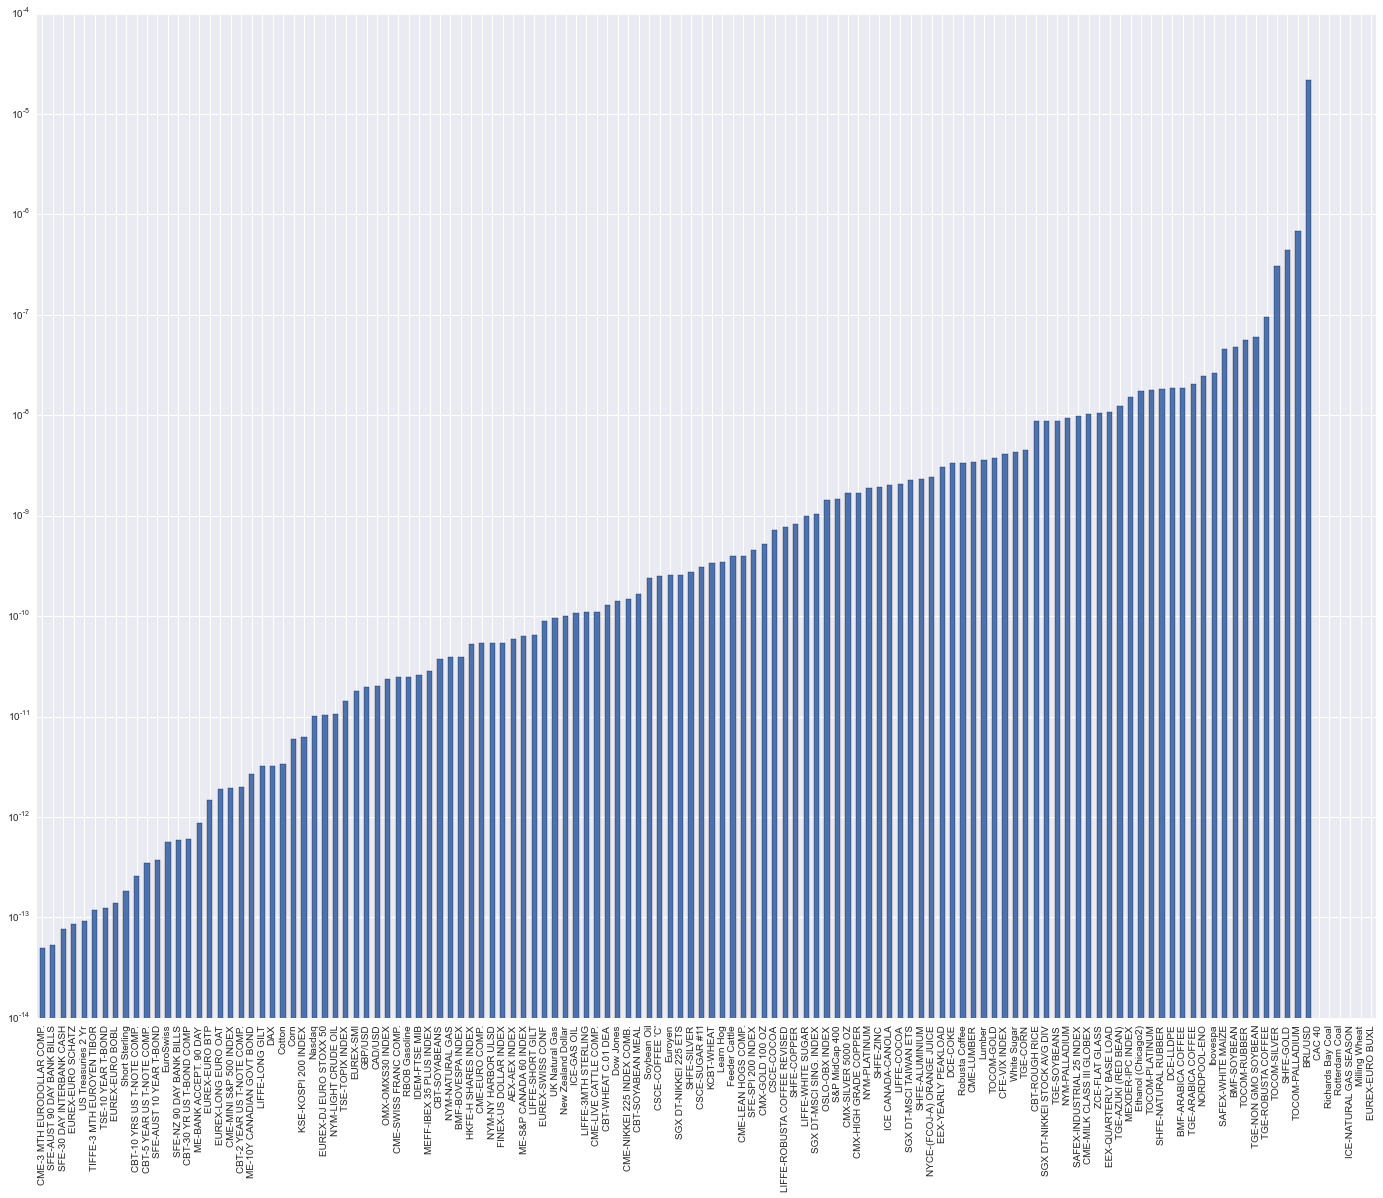

In [8]:
amihud.mean().dropna().sort_values().dropna().plot(kind='bar',logy=True)

In [13]:
amihud2=amihud.dropna(axis=1,how='all')

In [14]:
def tsmom_improved2(data,months):
    vol=pd.ewmstd(data.pct_change(),250)*math.sqrt(12)
    data = data.resample(rule='m',how='last')
    signal=data/data.shift(months)-1
    signal = signal /abs(signal)
    position=signal / vol 
    return position
data = cleansed.resample(rule='m').last()[:'2016']
pos=tsmom_improved2(data,12)
pnl=calc_pnl(pos,data)
sr=calc_Sharpe(pnl)

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: pd.ewm_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,com=250).std(bias=False)
  from IPython.kernel.zmq import kernelapp as app
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  app.launch_new_instance()


In [15]:
q_pnl, q_means=quantile_pnl_and_means(cleansed,amihud2,pnl,10)

tsmom_model.py:91: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  means.append(cleansed.resample(rule='m',how='last')[mkts].pct_change()[str(y)].mean().mean())


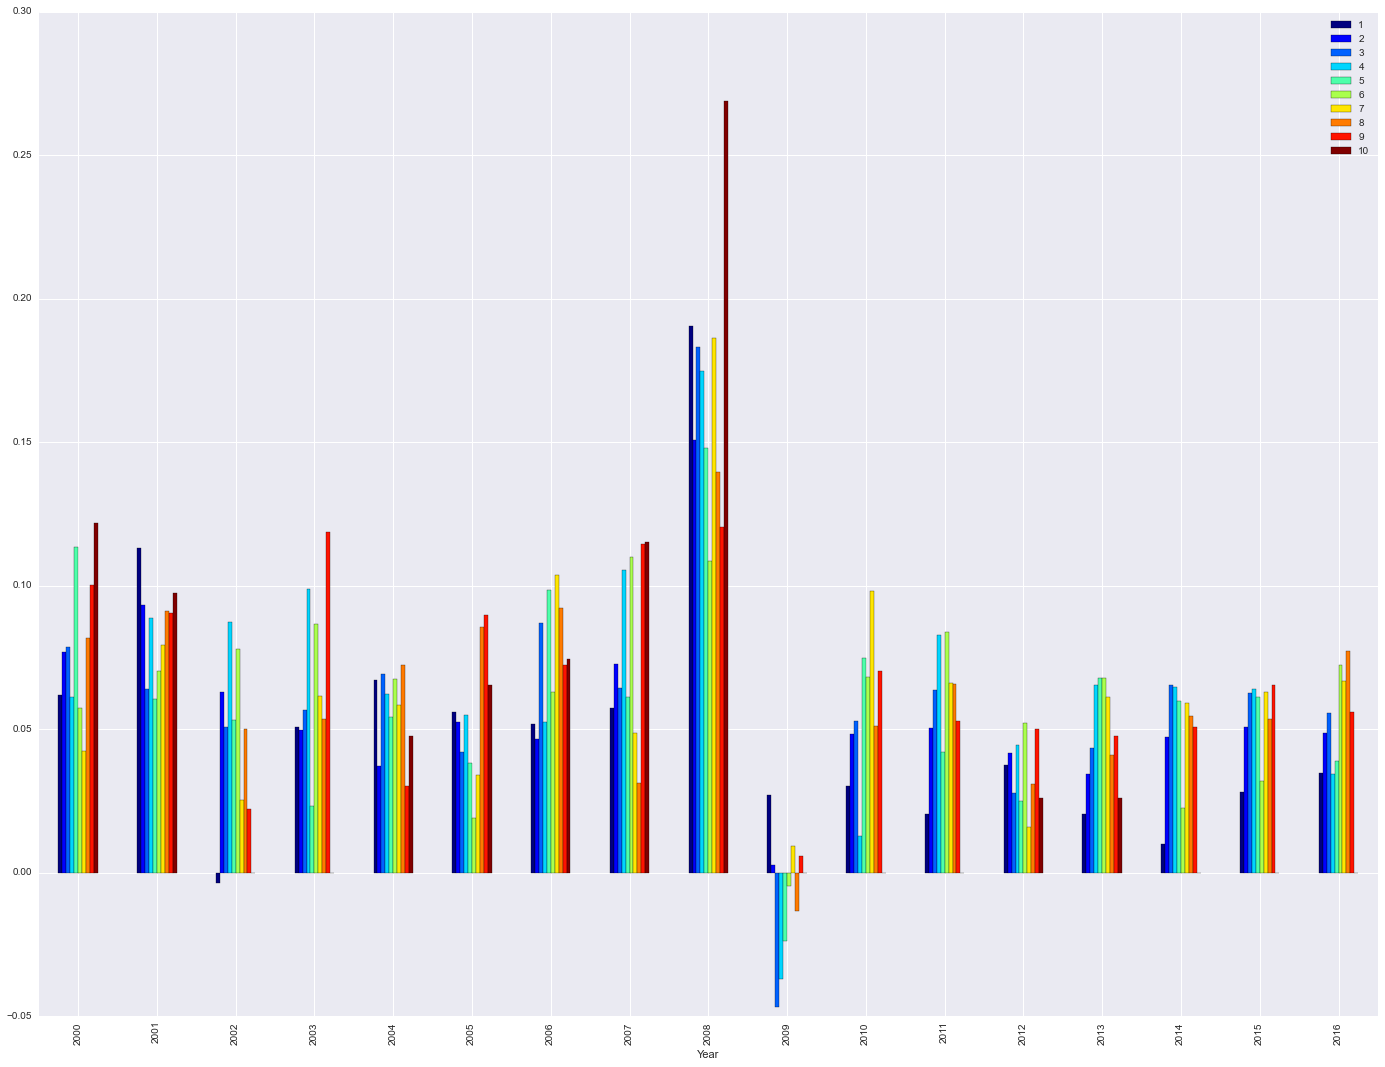

In [16]:
q_pnl.plot(kind='bar',colormap='jet')

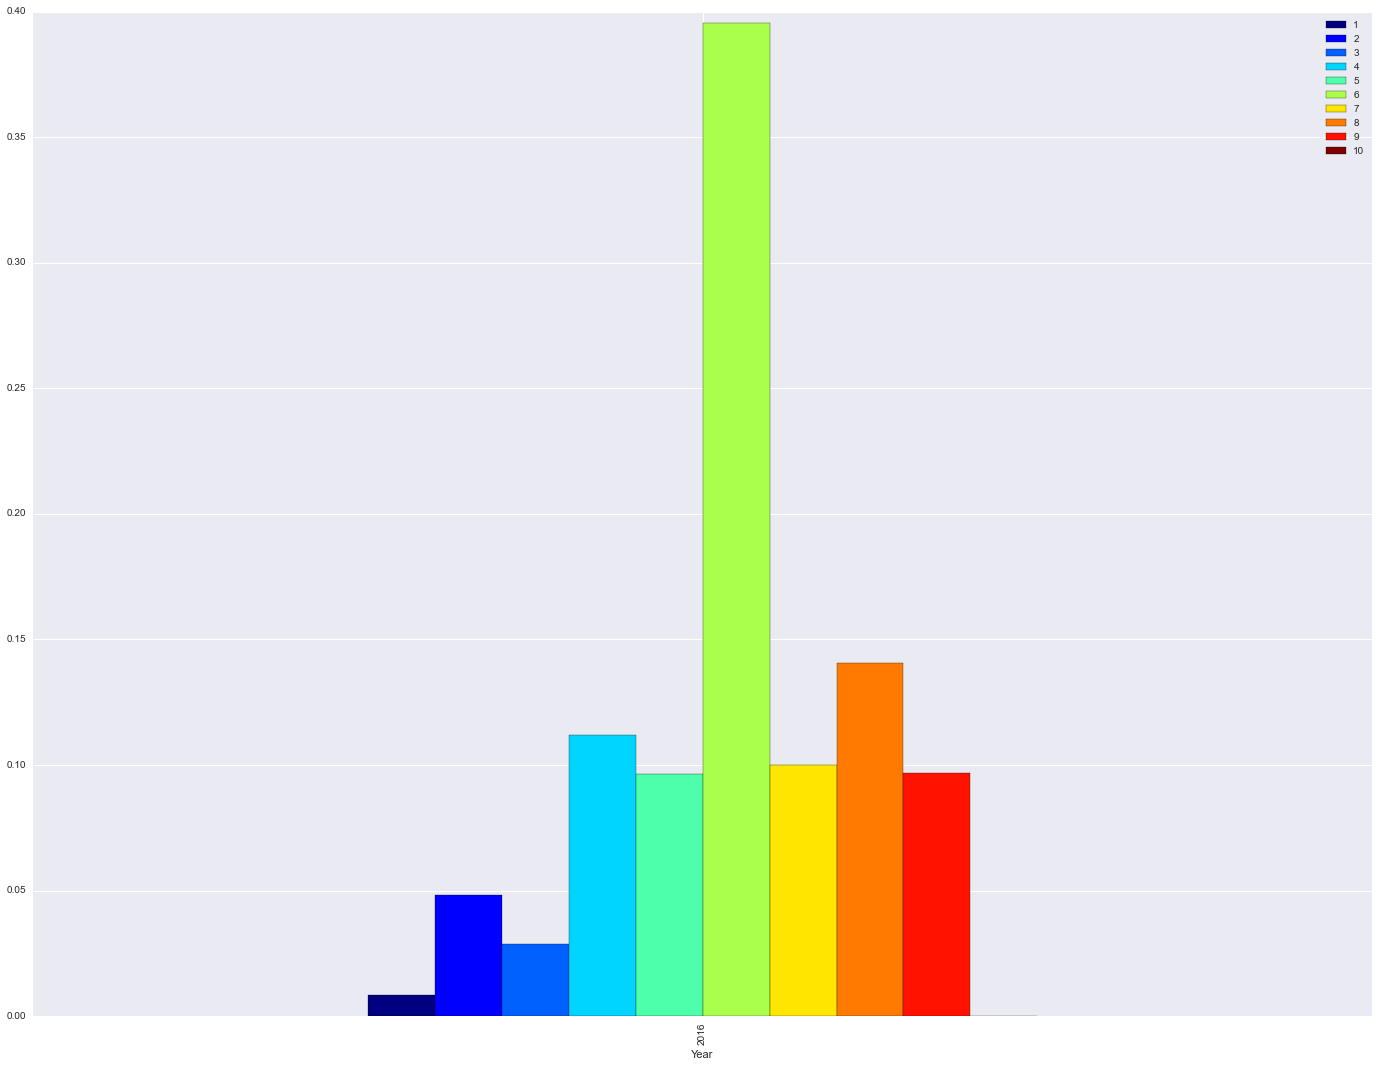

In [17]:
q_means.cumsum().tail(1).plot(kind='bar',colormap='jet')

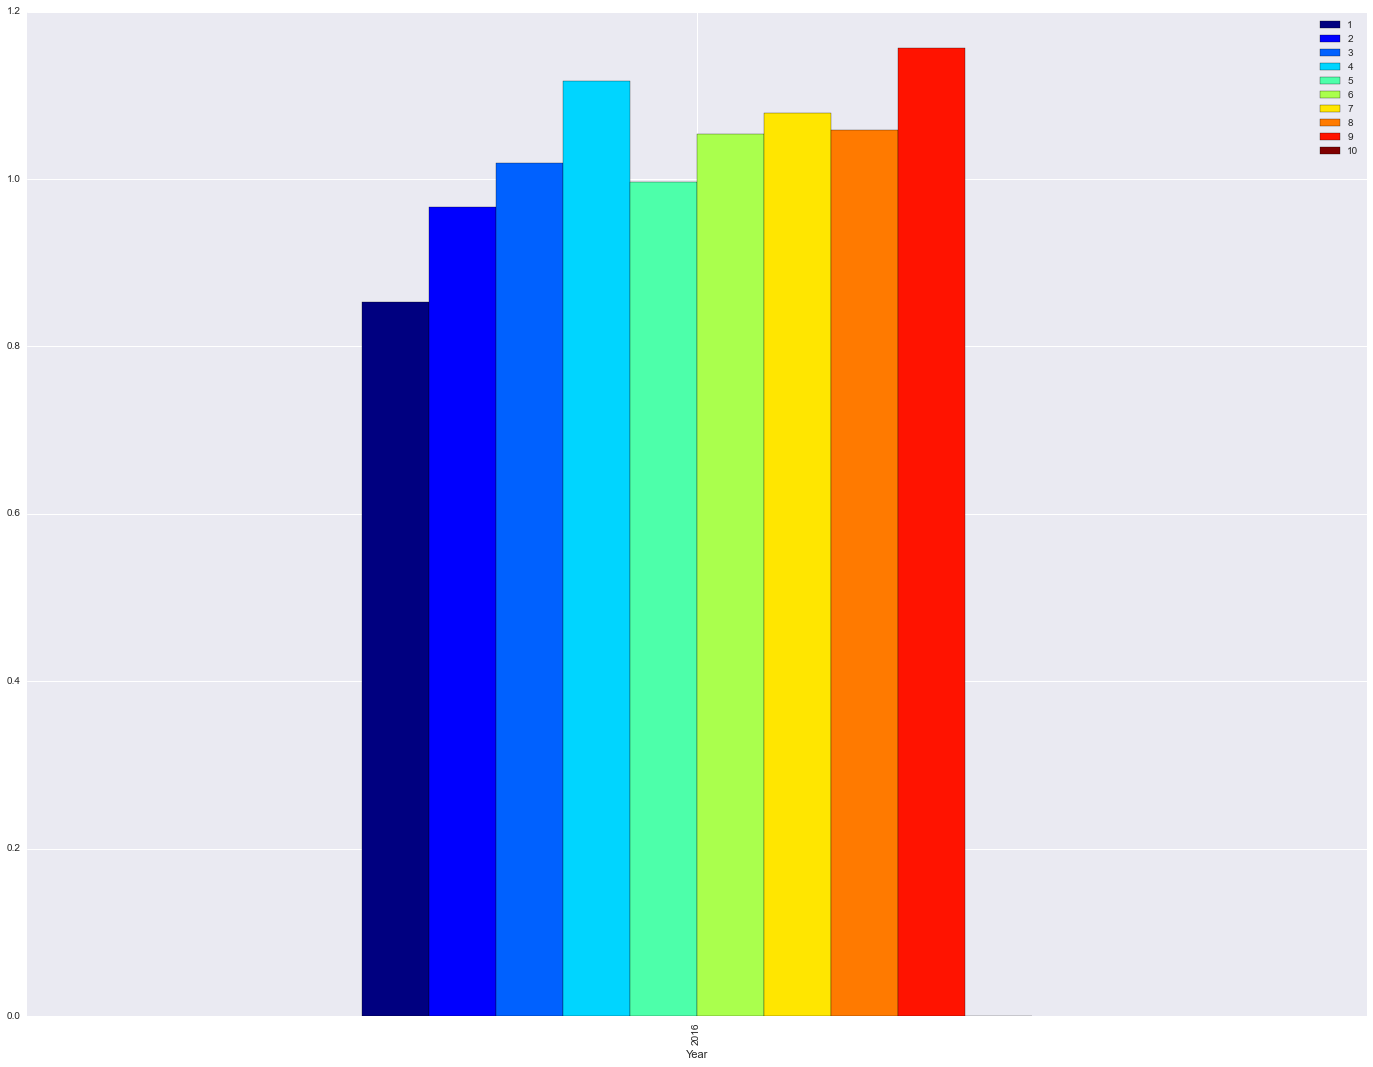

In [18]:
q_pnl.cumsum().tail(1).plot(kind='bar',colormap='jet')

In [19]:
q_means.mean()*1200

1      0.597693
2      3.412038
3      2.024695
4      7.904654
5      6.794166
6     27.906159
7      7.069532
8      9.919853
9      6.834803
10     8.079406
dtype: float64

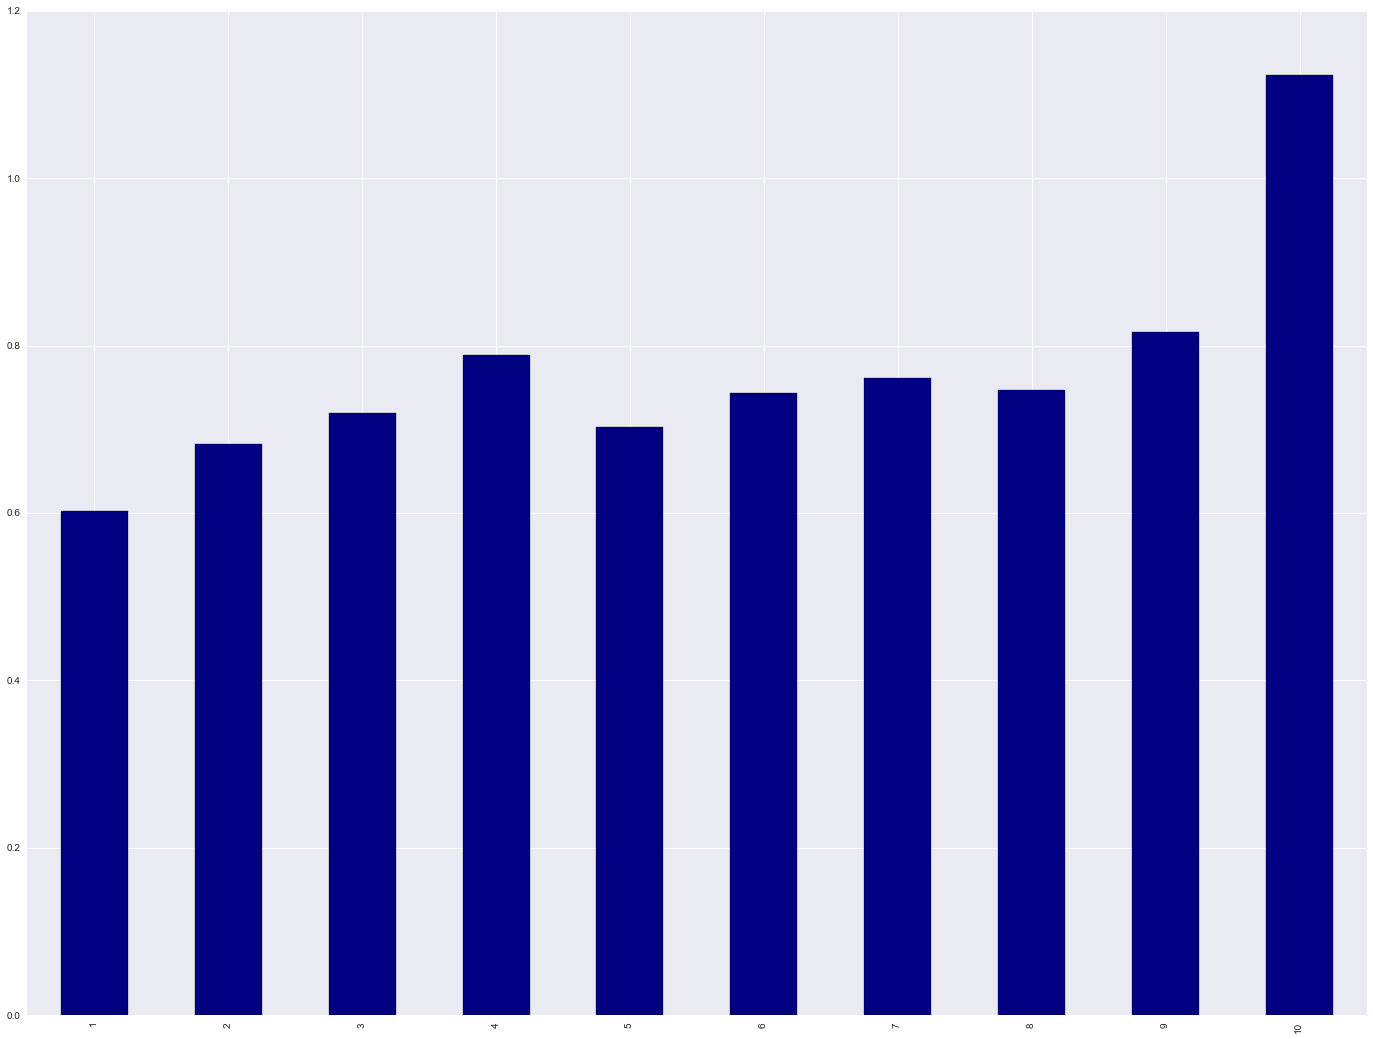

In [20]:
(q_pnl*12).mean().plot(kind='bar',colormap='jet')

# Amivest methodology


$$Amivest = \frac{r_t}{volume_t} $$

In [25]:
def calculate_amivest_liquidity(cleansed):
    volume=load_daily_volume()
    contract_size=load_maps()
    fx=load_fx()
    fx_map=contract_size.to_dict()['Currency']
    tick_map=contract_size.to_dict()['Tick Value']
    sector_map=contract_size.to_dict()['Sector']
    fx=fx.resample(rule='d',how='last')
    px=cleansed.resample(rule='d',how='last')
    total_vol=pd.DataFrame()
    for m in cleansed.columns:
        try:
            curr= str(fx_map[m])
            total_vol[m] = (px[m]/fx[curr]*volume[m]*tick_map[m]).ffill()[:'2016'] 
        except:
            print m
    return (total_vol/cleansed.pct_change().abs()).resample(rule='m',how='mean')

In [26]:
x = calculate_amivest_liquidity(cleansed)[:'2016']

MEXDER-10YR BOND
ZCE-RAPESEED MEAL
BMF-US DOLLAR
NORDPOOL-ENO QTR
EEX-MONTHLY PEAKLOAD
LIFFE-10Y E SWAPNOTE
LIFFE-2YR E SWAPNOTE
OSX-NIKKEI 225 INDEX
ENDEX-TTF GAS BASE LOAD
ENDEX-TTF GAS BASE LOAD QTR
ENDEX-TTF GAS BASE LOAD SEASON
Canadian Bankers Acceptance
Russian Ruble

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:17: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()


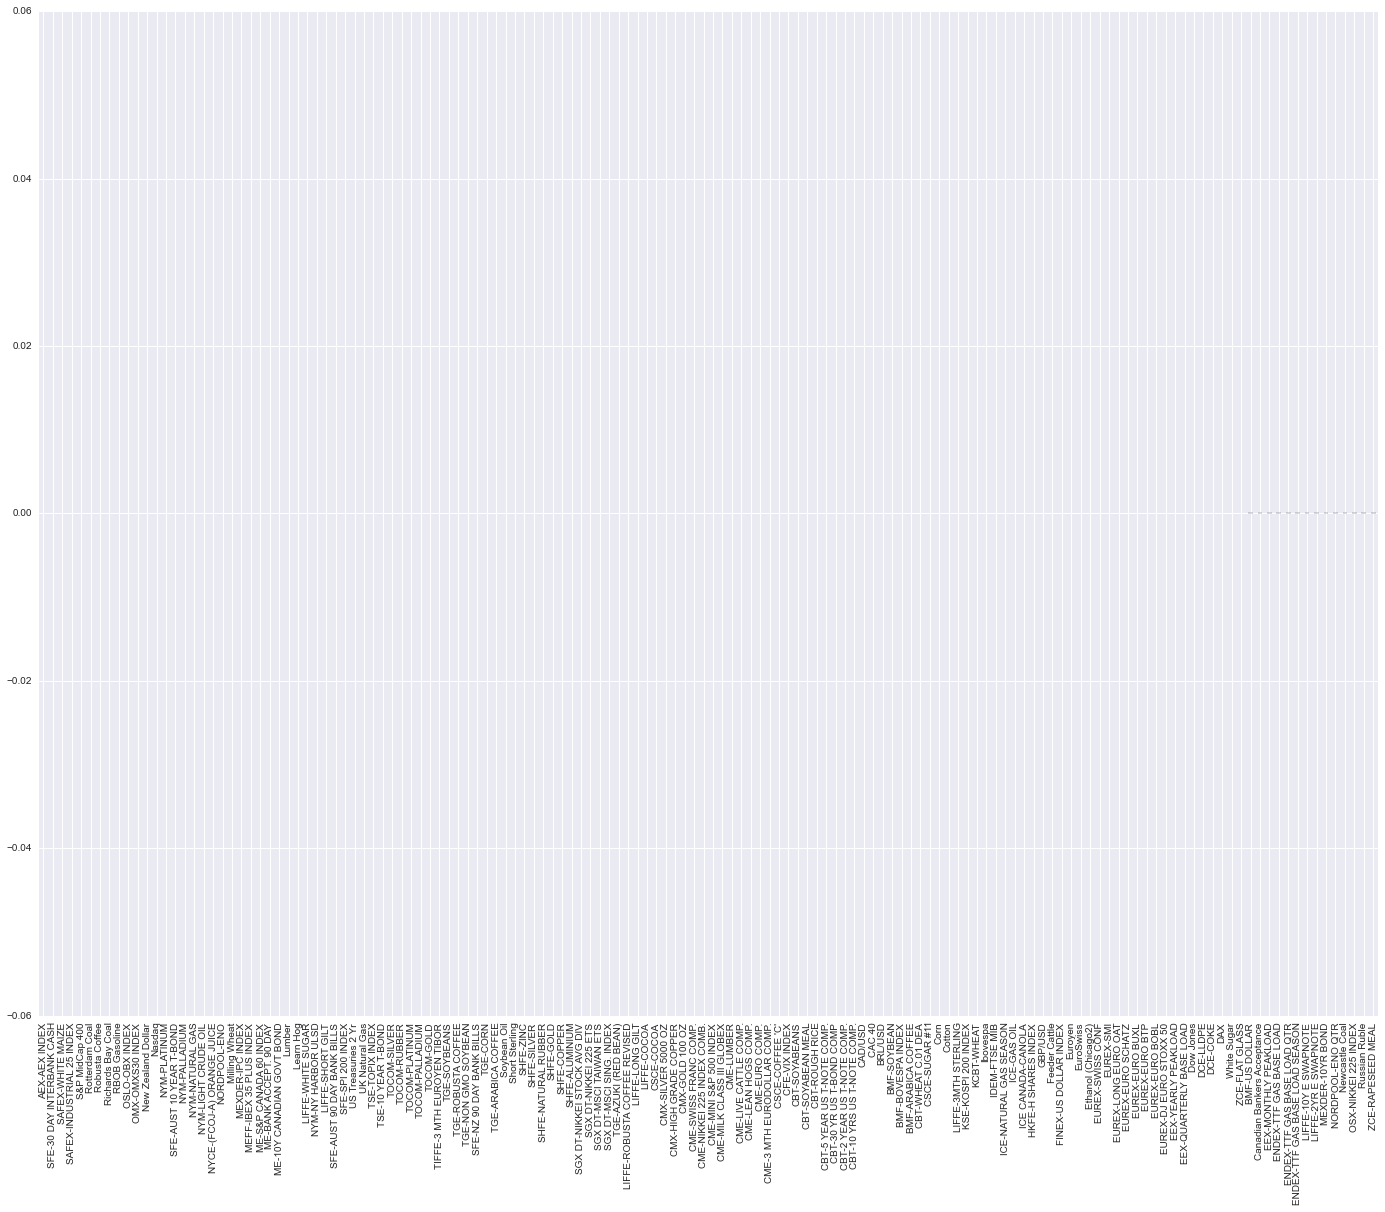

In [27]:
x.mean().sort_values().plot(kind='bar')